**Dependencies**

In [12]:
from station_data import *
from stream_processing import *
from event_detection import *
from catalogued_events import *
from stream_processing import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys
from report_generation import *
import matplotlib.pyplot as plt
from obspy import UTCDateTime
import torch
import sys


### This Notebook is for demonstrating the automated process of collection and analyzation of seismic streams against events from the catalogue. It‘s designed to be executed once every day and perform event identification and matching between collected streams and catalogued events.

**Initiating Parameters For The Day**

In [13]:
# Set date and station for studying423
date = UTCDateTime("2024-04-22") 
station = ['AM','R50D6','https://data.raspberryshake.org']

# Set global earthquake catalogue provider
providers = ["IRIS", "USGS", "EMSC"]

# Generate a path for all files to be saved to
date_folder = generate_data_path(date, station)

station_coordinates = get_coordinates(station)

**Download And Read Stream**

Data for 2024-04-22 already exist.
Reading data from path.
1 Trace(s) in Stream:
AM.R50D6.00.EHZ | 2024-04-21T23:00:00.004000Z - 2024-04-23T01:00:00.004000Z | 100.0 Hz, 9360001 samples


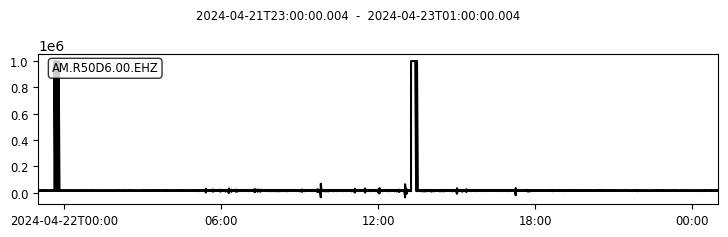

In [14]:
# Download and save original stream to file
stream_file = download_stream(date, station, path=date_folder, overwrite=False)

if stream_file:
    print("Reading data from path.")
    original_stream = read(stream_file)
    print(original_stream)
    original_stream.plot();
else:
    print("Error: No data file available to read.")
    

Processed Stream ( Demean, Detrend, Outlier Removal And Band Pass Filtering )

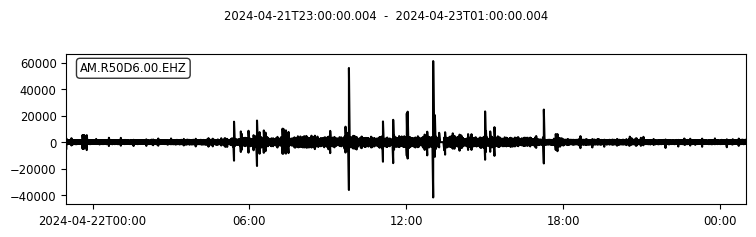

In [15]:
processed_stream = stream_process(original_stream)
processed_stream.plot();

Denoise Using Pretrained DeepDenoiser Model

CUDA available. Running on GPU
Stream saved to D:\Dissertation\data\AM.R50D6\2024-04-22\2024-04-22_AM.R50D6..Z.processed.mseed


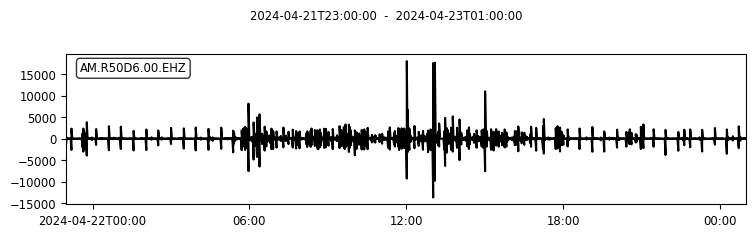

In [16]:
# Get pretrained model for denosing
denoiser_model = sbm.DeepDenoiser.from_pretrained("original")

# Denoising the stream 
denoised_stream = deep_denoiser(processed_stream, denoiser_model)

# Save processed stream to file
save_stream_to_file(denoised_stream, date_folder, date, station,"processed")

# Showing denoised stream
denoised_stream.plot();

Pre-trained Deep Learning Model

In [17]:
# Get pretrained model for phase picking
phase_picking_model = sbm.EQTransformer.from_pretrained("original")

# Threshold to filter out false positives
confidence_threshold = 0.7

# Detect P and S waves from stream
df_phase_picked, annotated_stream = predict_and_annotate(denoised_stream, phase_picking_model)

# Filter by confidence threshold
df_phase_picked = df_phase_picked[df_phase_picked['peak_confidence'] >= confidence_threshold]

# Show results
df_phase_picked

CUDA available. Running on GPU


,peak_time,peak_confidence,phase
11,2024-04-21T23:32:56.440000Z,0.711394,S
14,2024-04-21T23:40:52.830000Z,0.753472,S
15,2024-04-21T23:42:42.410000Z,0.749912,P
17,2024-04-21T23:47:09.000000Z,0.850203,P
23,2024-04-21T23:58:36.010000Z,0.885080,P
...,...,...,...
1343,2024-04-22T23:21:43.220000Z,0.739402,S
1345,2024-04-22T23:32:53.070000Z,0.724996,P
1363,2024-04-23T00:16:35.020000Z,0.798008,P
1379,2024-04-23T00:42:05.200000Z,0.851945,P


Save Picked Phases And Annotated Stream To Files

In [18]:
save_df_to_csv(df_phase_picked, date, date_folder, "phase_picked")
save_stream_to_file(annotated_stream, date_folder, date, station,"processed.annotated")

DataFrame saved to D:\Dissertation\data\AM.R50D6\2024-04-22\2024-04-22.phase_picked.csv
Stream saved to D:\Dissertation\data\AM.R50D6\2024-04-22\2024-04-22_AM.R50D6..Z.processed.annotated.mseed


Request Catalogue And Save To File

In [19]:
catalogue_path = request_catalogue(
    catalogue_providers= providers,
    station_information = station,
    station_location = station_coordinates,
    date = date,
    radmin=0,
    radmax=90,
    minmag=3,
    maxmag=10,
    path=date_folder,
    overwrite = True
)

catalogue = load_earthquake_catalog(catalogue_path)

if catalogue:
    print_catalogued(catalogue)
else:
    print("Error: No catalogue file available to read.")

Catalog saved to D:\Dissertation\data\AM.R50D6\2024-04-22\2024-04-22_IRIS.catalogue.xml
Reading catalogue from path.
----------------------------------------
78 Event(s) in Catalog:
2024-04-23T00:11:02.661000Z | +23.898, +121.598 | 5.2  mb
2024-04-23T00:04:05.608000Z | +23.803, +121.676 | 5.8  mww
...
2024-04-22T01:54:33.184000Z |  +3.724,  +93.033 | 4.2  mb
2024-04-22T01:11:57.452000Z | +27.680,  +56.035 | 4.0  mb
To see all events call 'print(CatalogObject.__str__(print_all=True))'



**Create a DataFrame for Catalogued Events with Predicted Arrival Times**

In [20]:
df_catalogued = process_catalogue(catalogue, get_coordinates(station))
df_catalogued

,event_id,time,lat,long,mag,mag_type,depth,epi_distance,P_predict,S_predict,catalogued,detected,P_detected,S_detected
0,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,13296.0,9755.277743,2024-04-23T00:23:51.101729,2024-04-23T00:34:33.407662,True,False,None,None
1,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,13118.0,9768.402629,2024-04-23T00:16:54.643660,2024-04-23T00:27:37.526696,True,False,None,None
2,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:03:49.290000,23.6992,121.6391,4.5,mb,20652.0,9776.590332,2024-04-23T00:16:37.432461,2024-04-23T00:27:19.780646,True,False,None,None
3,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T23:35:39.486000,23.8142,121.5956,4.3,mb,11844.0,9763.297320,2024-04-22T23:48:28.514604,2024-04-22T23:59:11.331907,True,False,None,None
4,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T23:02:44.117000,23.7274,121.5503,4.5,mwr,9729.0,9769.476836,2024-04-22T23:15:33.764633,2024-04-22T23:26:17.093491,True,False,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T06:40:45.111000,44.3632,140.2641,4.1,mb,256911.0,8442.983838,2024-04-22T06:52:03.650457,2024-04-22T07:01:25.159898,True,False,None,None
74,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T04:19:45.896000,24.1948,125.1205,4.6,mb,30348.0,9895.985439,2024-04-22T04:32:37.685028,2024-04-22T04:43:24.033156,True,False,None,None
75,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T02:12:43.836000,13.9919,-91.5175,4.1,mb,51407.0,8746.350296,2024-04-22T02:24:40.364723,2024-04-22T02:34:33.971864,True,False,None,None
76,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T01:54:33.184000,3.7245,93.0334,4.2,mb,10000.0,9966.566914,2024-04-22T02:07:31.135686,2024-04-22T02:18:22.691981,True,False,None,None


**Compare DataFrames And Merge Events Detected In Catalogue**

In [23]:
result_df =  match_and_merge(df_catalogued, df_phase_picked, time_tolerance = 10)
result_df

,event_id,time,lat,long,mag,mag_type,depth,epi_distance,P_predict,S_predict,catalogued,detected,P_detected,S_detected,P_peak_confidence,S_peak_confidence,peak_confidence
0,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:11:02.661000,23.8982,121.5981,5.2,mb,13296.0,9755.277743,2024-04-23T00:23:51.101729,2024-04-23T00:34:33.407662,True,False,None,None,NaN,NaN,NaN
1,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:04:05.608000,23.8026,121.6764,5.8,mww,13118.0,9768.402629,2024-04-23T00:16:54.643660,2024-04-23T00:27:37.526696,True,False,None,None,NaN,NaN,NaN
2,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-23T00:03:49.290000,23.6992,121.6391,4.5,mb,20652.0,9776.590332,2024-04-23T00:16:37.432461,2024-04-23T00:27:19.780646,True,True,2024-04-23T00:16:35.020000,None,0.798008,NaN,NaN
3,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T23:35:39.486000,23.8142,121.5956,4.3,mb,11844.0,9763.297320,2024-04-22T23:48:28.514604,2024-04-22T23:59:11.331907,True,False,None,None,NaN,NaN,NaN
4,smi:service.iris.edu/fdsnws/event/1/query?even...,2024-04-22T23:02:44.117000,23.7274,121.5503,4.5,mwr,9729.0,9769.476836,2024-04-22T23:15:33.764633,2024-04-22T23:26:17.093491,True,False,None,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-22T23:18:19.110000,None,NaN,NaN,0.700669
258,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,None,2024-04-22T23:21:43.220000,NaN,NaN,0.739402
259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-22T23:32:53.070000,None,NaN,NaN,0.724996
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,True,2024-04-23T00:42:05.200000,None,NaN,NaN,0.851945


**Final DataFrame Containing Information Saved**

In [24]:
save_df_to_csv(result_df, date, date_folder,"completed")

DataFrame saved to D:\Dissertation\data\AM.R50D6\2024-04-22\2024-04-22.completed.csv


### This Notebook ends here. All data collected, produced are saved to files and will be utilized for generation of contents for report or email notification in another Notebook.